# Gene set enrichment calculation based on gene expression pattern similarity

The tests indicates whether genes within gene set have more similari profiles than expected by chance - eg. are tightly regulated in that sample (of multiple measurments). By default both positive and negative associations are considered.

Similarity between gene profiles within gene sets is compared to similarity between random gene pairs. The significance of gene set enrichment is calculated with Welch's t-test and adjusted with BH FDR correction.

In [3]:
from orangecontrib.bioinformatics.geneset.__init__ import (list_all,load_gene_sets)
from timeGeneSetsObj import *
from statistics import (mean, stdev)
import matplotlib.pyplot as plt

In [2]:
#genes - Data frame of expression data with genes in rows.
# The data is specific for one replicate and genes with 0 expression in all data points are remouved.

## Calculate how many random pairs must be used to estimate similarity between random points

In [ ]:
sc=SimilarityCalculator()
ge=GeneExpression(genes)

similarities=[]
#Different number of pairs
pairN=[3,4,5,10,20,40,60,100,300,500,1000,5000,10000,50000,100000]
rscn=RandomSimilarityCalculatorNavigator(ge,sc)
#Calculate similarities summary statistics from different pair numbers
for pN in pairN:
    print(pN)
    similarities.append(rscn.similarities(pN,True))
sds=[]
means=[]
#Extract means and standard deviations from summary statistics
for s in similarities:
    means.append(s.mean_val)
    sds.append(s.std)
plt.scatter(pairN,means)
plt.plot(pairN,means)
plt.xscale('log')
plt.scatter(pairN,sds)
plt.plot(pairN,sds)
plt.xlabel('n random pairs')
plt.ylabel('mean (blue) and stdev (orange) similarity')


Exmples of summary statistics based on n of used pairs for different similarity calculation methods.

Spearman:
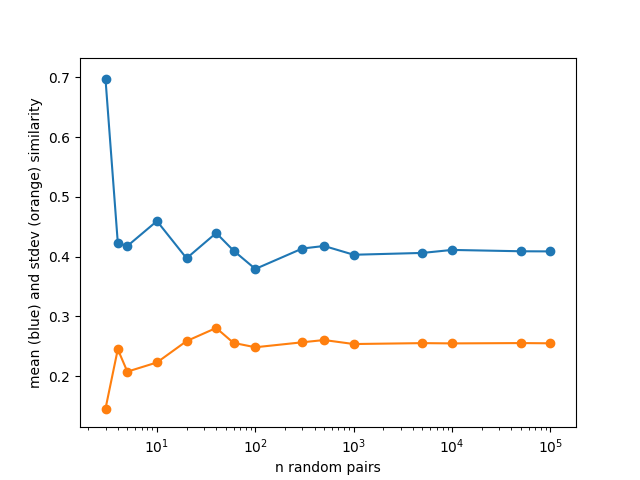

Pearson:
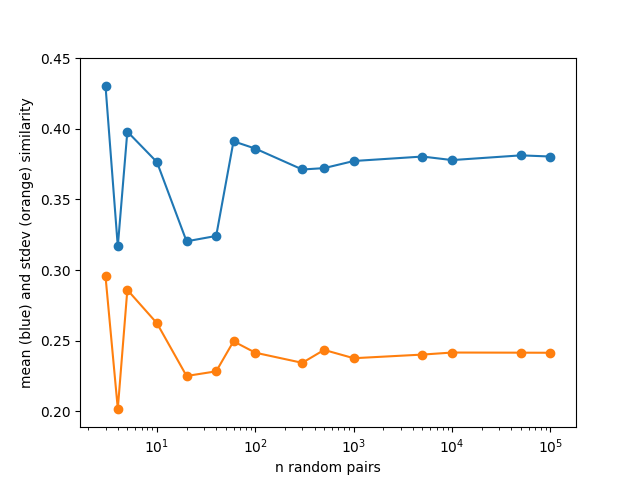

Cosine, normalised to mean 0 and stdev 1:
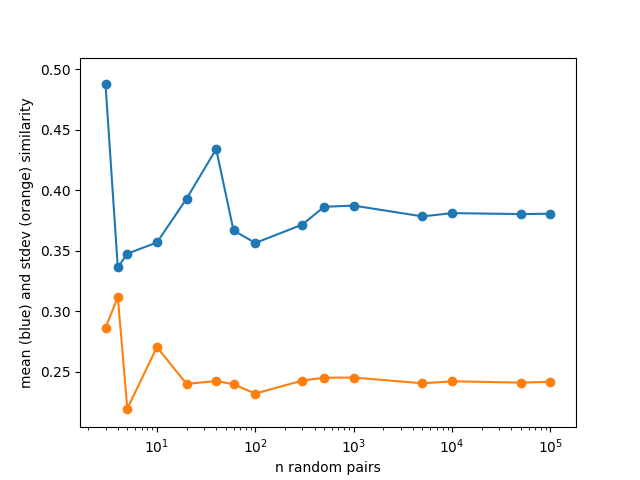

Thus it was decided that similarities between random points can be estimated with 5000 pairs.

## Determine if similarities within large gene sets can be estimated with limited number of pairs

In [ ]:
#Calculate MSE for different number of used pairs for estimation of similarity
#Parameters: AX4_average data, pearson correlation, random similarities calculated on 5000 pairs
sc=SimilarityCalculator(similarity_type='correlation_pearson')
ec=EnrichmentCalculatorFactory.make_enrichment_calculator(ge,sc)
#Example gene sets retrieval
list_of_genesets = list_all(organism='44689')
#index - check which in list_of_genesets
gene_sets=load_gene_sets(list_of_genesets[index],'44689')
#Use only gene sets with more possible gene pairs than latter used pairs for calculations
large_sets=[]
for s in gene_sets:
    if len(s.genes)>300:
        large_sets.append(s)
#Reduce number of sets:
max_sets=20
if len(large_sets)>max_sets:
    large_sets=large_sets[:max_sets]

#Number of pairs used for similarity estimation
pairN=[500,800,1000,2000,3500,5000,10000,20000,7500]
results=[]
#All similarities calculated
res=ec.calculate_enrichment(large_sets)
results.append(res)
#Only subset of similarities calculated (max_pairs)
for n in pairN:
    print(n)
    res=ec.calculate_enrichment(large_sets,max_pairs=n)
    results.append(res)
#MSE
mse=[]
max_se=[]
for n in range(1,len(results)):
    errorsSquared=[]
    for s in range(max_sets):
        padjOriginal=results[0][s].padj
        padjShortened=results[n][s].padj
        errSq=(padjOriginal-padjShortened)**2
        errorsSquared.append(errSq)
    mse.append(mean(errorsSquared))
    max_se.append(max(errorsSquared))
#Sort for plotting
mse=[x for _, x in sorted(zip(pairN,mse), key=lambda pair: pair[0])]
max_se=[x for _, x in sorted(zip(pairN,max_se), key=lambda pair: pair[0])]
pairN=sorted(pairN)
plt.plot(pairN,mse)
plt.scatter(pairN,mse)
plt.plot(pairN,max_se)
plt.ylabel('MSE (blue) and max SE (orange) padj')
plt.xlabel('n pairs')


Results:
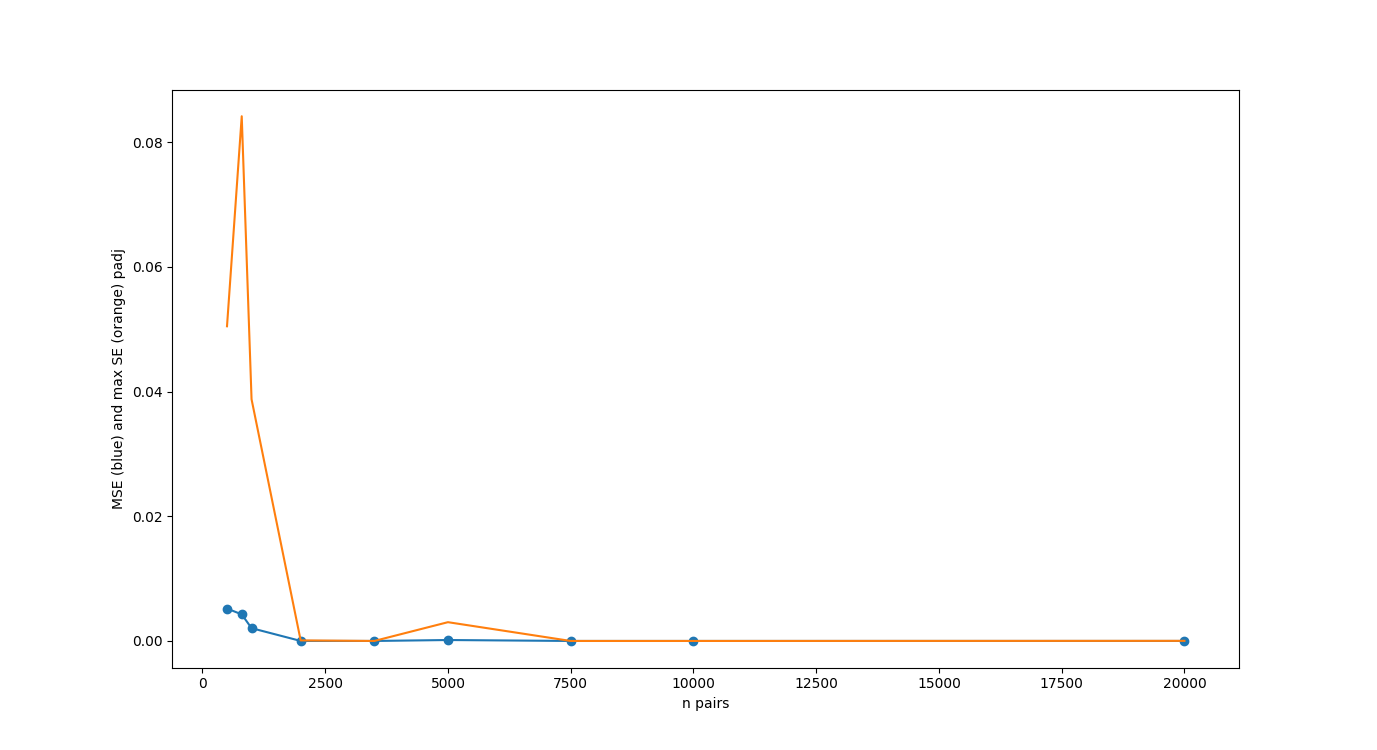

## Example result

Calculated enrichment for Dicty phenotype gene sets for each replicate. Parameters: pearson correlation, 5000 pairs for random similarity, 3000 pairs as max for each gene set.  Replicate results from individual strains were merged by requiring individual gene sets to be present in at least two replicates, averaging p adjusted.

The runtimes were one to a couple of minutes per replicate (dependent on characteristics of gene sets used). Not all gene sets were tested so far so it is possible that some run times might be even longer. 

This data was used to create a table of starins and gene sets, containing p adjusted as table value. This was plotted in Orange.

When examining padj distribution it was discovered that many gene sets had p adjusted well below 0.05. - To obtain a narrower set of gene sets with well correlated genes any padj greater than 5th percentile padj was changed to 1 for plotting in Orange. To try to improve heatmap resolution table was perprcessed before importing in Orange by transfroming it with -10log10.

These transformations also affect strain clustering in heatmap.

Original padj values:

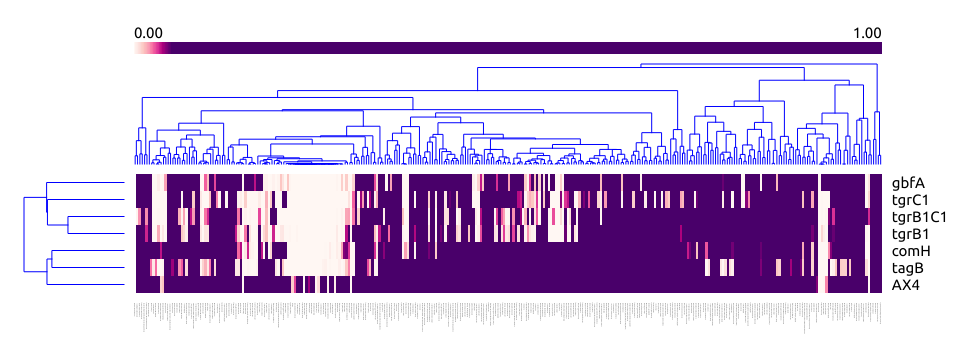


Top 5% padj filtering:
Many of top enriched phenotypes seem to be relevant for fruiting body development. What I find odd is the wild type gene set enrichment pattern - is it possible that WT gene set is in fact marker for unicelaular stage WT?

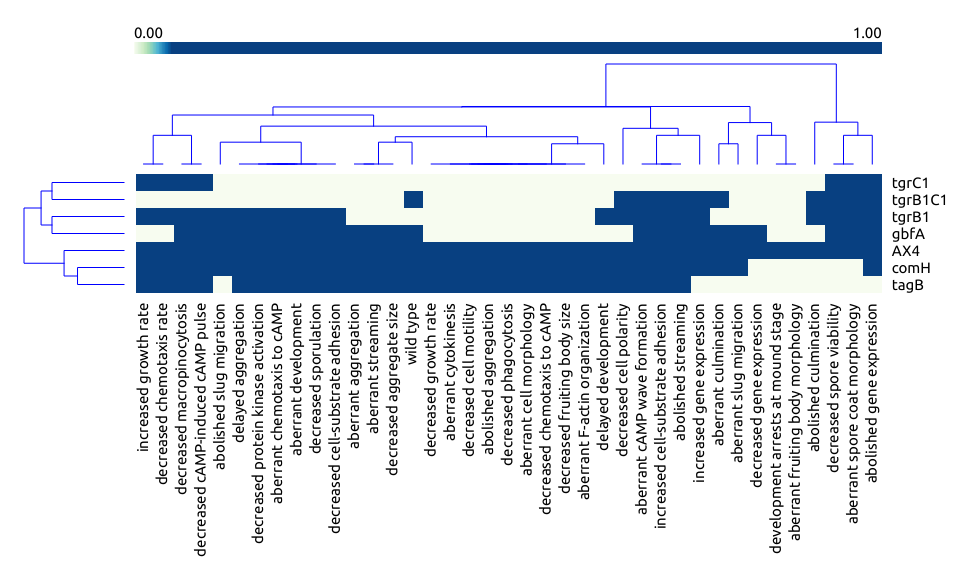

-10log10 transformed padj
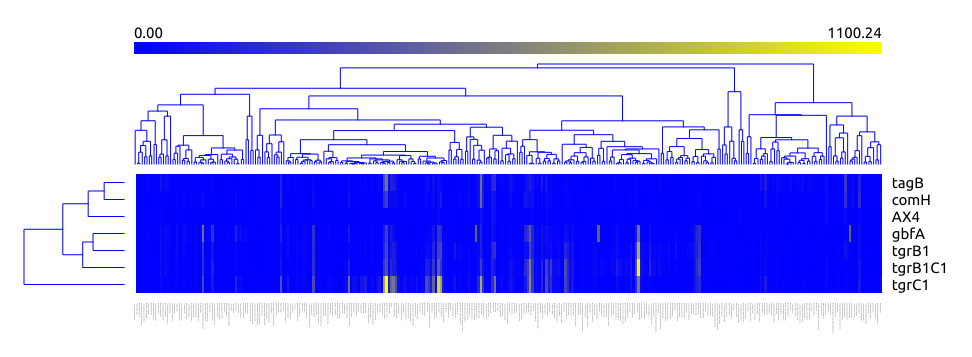

In [ ]:
#Main code parts used for above analysis:

#Calculation for single replicate:
ge=GeneExpression(genes)
ec=EnrichmentCalculatorFactory.make_enrichment_calculator(ge,sc)
result=ec.calculate_enrichment(gene_sets,3000)
resDict=dict()
for r in result:
    resDict[r.gene_set.name]=r.padj


#Retain sets that are present in at least min_replicates replicates at level of max padj, average the padj
#Reps data - list of enrichment data, where list elements are dicts (resDict) of gene set names (key) and padj (value)
#Returns in same format as resDict
def merge_from_replicates(reps_data:list, max_padj,min_reps:int=2)->dict:
    merged=dict()
    for data in reps_data:
        for gene_set,padj in data.items():
            if padj<=max_padj:
                if gene_set in merged.keys():
                    merged[gene_set].append(padj)
                else:
                    merged[gene_set]=[padj]
    filtered=dict()
    for gene_set,padjs in merged.items():
        if len(padjs)>=min_reps:
            filtered[gene_set]=mean(padjs)
    return filtered

#Merge replicates data:
#Data of individual strains, keys are strain names, values are strain results (as described below)
strain_data=dict()
#Add data of each replicate (resDict) to reps list
reps=[]
#Decided not to filter on pval as Ornage cant plot heatmap NaN well
merged=merge_from_replicates(reps,1)
strain_data[strain]=merged
#Make enrichment table
strains=[]
datas=[]
for strain,data in strain_data.items():
    strains.append(strain)
    datas.append(data)
table_enriched=pd.DataFrame(datas)
table_enriched.index=strains

#Retain only best pvals, replace others with 1
padjs=table_enriched.values.flatten()
table_filtered=table_enriched.copy()
boundary=np.nanpercentile(padjs,5)
table_filtered[table_filtered>boundary]=1

#Log transform -10log10(val)
table_log=np.log10(table_enriched)
table_log=table_log*-10


## Conclusion

It seems that results are biologically meaningful. 

However, the run times are sub optimal. One of the ways this could be improved is by using only gene sets low in gene set hierarchy, where possible. - Eg. not using very functionally broad gene sets with many genes.